<a href="https://colab.research.google.com/github/jiin124/Dacon/blob/main/%ED%95%AD%EA%B3%B5%EC%82%AC%20%EA%B3%A0%EA%B0%9D%20%EB%A7%8C%EC%A1%B1%EB%8F%84%20%EC%98%88%EC%B8%A1%20%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C/%ED%95%AD%EA%B3%B5%EC%82%AC_%EA%B3%A0%EA%B0%9D_%EB%A7%8C%EC%A1%B1%EB%8F%84_%EC%98%88%EC%B8%A1_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [23]:
train=pd.read_csv('/content/drive/MyDrive/airline_dataset/train.csv')
test=pd.read_csv('/content/drive/MyDrive/airline_dataset/test.csv')
sample=pd.read_csv('/content/drive/MyDrive/airline_dataset/sample_submission.csv')

In [3]:
train.head(1).transpose()

,0
id,1
Gender,Female
Customer Type,disloyal Customer
Age,22
Type of Travel,Business travel
Class,Eco
Flight Distance,1599
Seat comfort,3
Departure/Arrival time convenient,0
Food and drink,3


In [24]:
numeric_feature = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_feature = ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 
           'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 
           'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']

categorical_feature = ['Gender', 'Customer Type', 'Type of Travel', 'Class']

## 전처리

### 지연시간 로그 씌우기



In [25]:
train['Departure Delay in Minutes']=np.log1p(train['Departure Delay in Minutes'])
train['Arrival Delay in Minutes']=np.log1p(train['Arrival Delay in Minutes'])

test['Departure Delay in Minutes']=np.log1p(train['Departure Delay in Minutes'])
test['Arrival Delay in Minutes']=np.log1p(test['Arrival Delay in Minutes'])

In [6]:
train['Ease of Online booking'][train['Ease of Online booking']==0]=3
train['Online boarding'][train['Online boarding']==0]=3

In [7]:
for i in range(len(train)):
  for feature in ordinal_feature:
    if train[feature].iloc[i]==0:
      train[feature].iloc[i]=np.nan

for i in range(len(test)):
  for feature in ordinal_feature:
    if test[feature].iloc[i]==0:
      test[feature].iloc[i]=np.nan

### 파생변수

딜레이가 됐는지 안됐는지

In [26]:
train['Delayed']=(train['Departure Delay in Minutes']
                  +train['Arrival Delay in Minutes']).apply(lambda x:0 if x>0 else 1)
test['Delayed']=(test['Departure Delay in Minutes']+
                 test['Arrival Delay in Minutes']).apply(lambda x:0 if x>0 else 1)

In [27]:

train = train.drop(['Food and drink', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 'id'], axis = 1)
test = test.drop(['Food and drink', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 'id'], axis = 1)

In [29]:
train.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Arrival Delay in Minutes,target,Delayed
0,Female,disloyal Customer,22,Business travel,Eco,1599,3,3,4,3,4,4,5,4,4,4,5,4,0.000000,0,1
1,Female,Loyal Customer,37,Business travel,Business,2810,2,4,1,4,3,5,5,4,2,1,5,2,2.944439,0,0
2,Male,Loyal Customer,46,Business travel,Business,2622,1,1,4,5,5,4,4,4,4,5,4,3,0.000000,1,1
3,Female,disloyal Customer,24,Business travel,Eco,2348,3,3,3,3,3,3,2,4,5,3,4,3,1.098612,0,0
4,Female,Loyal Customer,58,Business travel,Business,105,3,3,4,4,5,4,4,4,4,4,4,5,0.000000,1,1


In [43]:
X_train=train.drop('target',axis=1)
y_train=train['target']
X_test=test

In [14]:
pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [47]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV

estimators=[]

lgbm=LGBMClassifier()
estimators.append(lgbm)

xgb=XGBClassifier()
estimators.append(xgb)

cat=CatBoostClassifier()
estimators.append(cat)

#모듈의 파라미터들을 할당할 리스트 만들어주기
params=[]

params_lgbm={
    'n_estimators':[90,100,200,300],
    'min_samples_split':[1,2,3,4],
    'learning_rate':[0.05,0.1,0.5],
    'max_depth':[2,3,4]
}
params.append(params_lgbm)

params_xgb={'n_estimatros':[100,300,500],
            'learning_rate':[0.05,0.1,0.3],
            'max_depth':[3,5,7],
            'subsample':[0.1,0.3]}

params.append(params_xgb)

params_cat={
    'learning_rate':[0.05,0.1,0.3]
}
params.append(params_cat)

In [48]:
from tqdm.auto import tqdm

def gridSearchCV(models,params):
  best_models=[]

  for i in tqdm(range(0,len(models))):
    model_grid=GridSearchCV(models[i],params[i],n_jobs=-1,verbose=1,cv=5)
    model_grid.fit(X_train,y_train)
    best_models.append(model_grid.best_estimator_)
  return best_models

best_model_list=gridSearchCV(estimators,params)

  0%|          | 0/3 [00:00<?, ?it/s]

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
0:	learn: 0.6414810	total: 2.64ms	remaining: 2.64s
1:	learn: 0.5978798	total: 4.81ms	remaining: 2.4s
2:	learn: 0.5582856	total: 6.92ms	remaining: 2.3s
3:	learn: 0.5286735	total: 9.24ms	remaining: 2.3s
4:	learn: 0.4981356	total: 11.7ms	remaining: 2.33s
5:	learn: 0.4728419	total: 14ms	remaining: 2.32s
6:	learn: 0.4496645	total: 16.5ms	remaining: 2.33s
7:	learn: 0.4335964	total: 18.8ms	remaining: 2.33s
8:	learn: 0.4191630	total: 21.2ms	remaining: 2.33s
9:	learn: 0.4015214	total: 23.7ms	remaining: 2.35s
10:	learn: 0.3883718	total: 26.3ms	remaining: 2.36s
11:	learn: 0.3764279	total: 28.8ms	remaining: 2.37s
12:	learn: 0.3605259	total: 31.2ms	remaining: 2.37s
13:	learn: 0.3497604	total: 33.4ms	remaining: 2.35s
14:	learn: 0.3405346	total: 35.9ms	remaining: 2.36s
15:	learn: 0.3326273	total: 38.2ms	remaining: 2.35

In [49]:
best_model_list

[LGBMClassifier(learning_rate=0.5, max_depth=3, min_samples_split=1,
                n_estimators=200),
 XGBClassifier(max_depth=7, n_estimatros=100, subsample=0.3),

In [50]:
best_models=[
             ('lgbm',LGBMClassifier(learning_rate=0.5, max_depth=3, min_samples_split=1,
                n_estimators=200)),
             ('xgb',XGBClassifier(max_depth=7, n_estimatros=100, subsample=0.3)),
             ('cat', CatBoostClassifier())
]

from sklearn.ensemble import VotingClassifier

voting=VotingClassifier(estimators=best_models)
voting.fit(X_train,y_train)

Learning rate set to 0.016469
0:	learn: 0.6755699	total: 2.33ms	remaining: 2.33s
1:	learn: 0.6595262	total: 4.86ms	remaining: 2.43s
2:	learn: 0.6435122	total: 7.23ms	remaining: 2.4s
3:	learn: 0.6305581	total: 9.6ms	remaining: 2.39s
4:	learn: 0.6162054	total: 11.8ms	remaining: 2.35s
5:	learn: 0.6029985	total: 14.3ms	remaining: 2.36s
6:	learn: 0.5899722	total: 16.4ms	remaining: 2.33s
7:	learn: 0.5783815	total: 18.6ms	remaining: 2.31s
8:	learn: 0.5677542	total: 21ms	remaining: 2.31s
9:	learn: 0.5551462	total: 23.4ms	remaining: 2.31s
10:	learn: 0.5465129	total: 25.7ms	remaining: 2.31s
11:	learn: 0.5355142	total: 27.9ms	remaining: 2.3s
12:	learn: 0.5260926	total: 30.1ms	remaining: 2.29s
13:	learn: 0.5163609	total: 32.5ms	remaining: 2.29s
14:	learn: 0.5076295	total: 35.8ms	remaining: 2.35s
15:	learn: 0.4988834	total: 38.9ms	remaining: 2.39s
16:	learn: 0.4910105	total: 43.3ms	remaining: 2.5s
17:	learn: 0.4830714	total: 46.9ms	remaining: 2.56s
18:	learn: 0.4756210	total: 49.3ms	remaining: 2.54

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(learning_rate=0.5, max_depth=3,
                                             min_samples_split=1,
                                             n_estimators=200)),
                             ('xgb',
                              XGBClassifier(max_depth=7, n_estimatros=100,
                                            subsample=0.3)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7f56ffcf5f50>)])

In [51]:
pred=voting.predict(X_test)
pred

array([1, 0, 1, ..., 0, 1, 1])

In [52]:
sample

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1995,1996,0
1996,1997,0
1997,1998,0
1998,1999,0


In [53]:
submit=sample.copy()
submit['target']=pred
submit.to_csv('submit.csv',index=False)

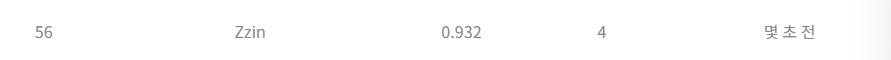